In [319]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import seaborn as sns
from skimage import filters
import urllib, io

from IPython.display import Image, display

import ee


In [ ]:
ee.Initialize()

In [173]:
# define location (Dubai)
geometry = ee.Geometry.Polygon([[[54.94803425942996, 24.96652872736307],
          [55.033264838241735, 24.968551791222385],
          [55.03223484885575, 25.040348953381287],
          [54.94803425837563, 25.039649067823706]]])

In [420]:
# get images
images = ee.ImageCollection("LANDSAT/LC8_L1T_TOA")

image = images.filterBounds(geometry).filterDate('2014-01-01', '2015-01-01') \
    .reduce(ee.Reducer.percentile([25])).rename(ee.Image(images.first()).bandNames())
    
ndwi = image.reproject(ee.Projection('EPSG:3857').atScale(30)) \
    .normalizedDifference(['B3', 'B5'])    

In [427]:
def get_path(image):
    return image.getThumbURL({'region' : geometry.toGeoJSON(), 'format': 'png'})

def show(image, path_out):
    path = get_path(image)
    
    if path_out:
        urllib.request.urlretrieve(path, path_out)

    display(Image(url=get_path(image)))

In [453]:
im = ee.ImageCollection.fromImages([
        ndwi.visualize(**{'min':-0.5, 'max':0.5, 'palette':['ffffff', '000000']})
    ]).mosaic()

show(im, 'ndwi.png')

In [433]:
edge = ee.Algorithms.CannyEdgeDetector(ndwi, 0.5, 1)

im = ee.ImageCollection.fromImages([
        ndwi.visualize(**{'min':-0.5, 'max':0.5, 'palette':['ffffff', '000000']}),
        edge.mask(edge).visualize(**{'palette':['ff0000']})
    ]).mosaic()

show(im, 'ndwi_edges.png')

In [444]:
ndwi_buffer = ndwi.mask(edge.focal_max(240, 'square', 'meters'))

im = ee.ImageCollection.fromImages([
        ee.Image(1).visualize(**{'palette':['ffffff']}),
        ndwi_buffer.mask(edge).visualize(**{'min':-0.5, 'max':0.5, 'palette':['ffffff', '000000']})
    ]).mosaic()

show(im, 'ndwi_buffer.png')

In [445]:
ndwi_buffer = ndwi.mask(edge.focal_max(30, 'square', 'meters'))

hist = ndwi_buffer.reduceRegion(ee.Reducer.histogram(150), geometry, 30).getInfo()

In [408]:
values = ndwi_buffer.reduceRegion(ee.Reducer.toList(), geometry, 30).getInfo()

In [409]:
th = filters.threshold_otsu(np.array(values['nd']))
print(th)

0.192428974219


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(-1, 1)

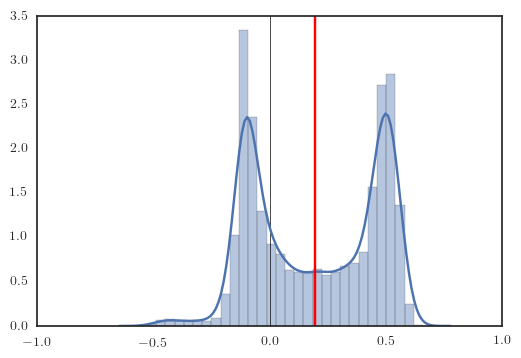

In [412]:
sns.set_style('white')
f = plt.figure()
plt.plot([0, 0], [0, 3.5], 'k-', lw=0.5)
sns.distplot(values['nd'])
plt.plot([th, th], [0, 3.5], 'r-')
plt.xlim(-1, 1)

In [413]:
# detect water
water = ndwi.gt(th)

In [428]:
im = ee.ImageCollection.fromImages([
        image.visualize(**{'min':0.03, 'max':0.5, 'bands': ['B4', 'B3', 'B2']}),
        water.mask(water).visualize(**{'opacity':0.6, 'palette':['0000ff']}),
        
    ]).mosaic()

show(im, 'final.png')

## Figure

In [422]:
from matplotlib import rc,rcParams
rc('text',usetex=True)

params = {'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']}
plt.rcParams.update(params)


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


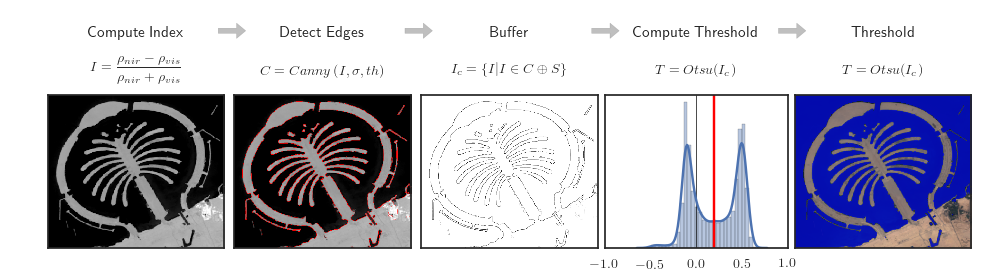

In [460]:
f = plt.figure(figsize=(12,3))
gs = gridspec.GridSpec(3, 5, height_ratios=[0.2,0.3,1] )

gs.update(wspace=0.02, hspace=0.02) # set the spacing between axes. 

def add_box(r, c):
    ax = plt.subplot(gs[r,c])
    ax.set_axis_off()
    
    # ax.add_patch(patches.Rectangle((0, 0), 1, 1, alpha=0.1))

    return ax
    
ax = add_box(0,0)
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Compute Index', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = add_box(0,1)
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Detect Edges', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = add_box(0,2)
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Buffer', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = add_box(0,3)
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Compute Threshold', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = add_box(0,4)
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Threshold', fontweight='bold', fontsize=11, horizontalalignment='center')

ax = add_box(1,0)
ax.text(0.5, 0.5, r'$I=\dfrac{\rho_{nir}-\rho_{vis}}{\rho_{nir}+\rho_{vis}}$', fontsize=10, ha='center', va='center')
ax = add_box(1,1)
ax.text(0.5, 0.5, r'$C=Canny\left(I,\sigma,th\right)$', fontsize=10, ha='center', va='center')
ax = add_box(1,2)
ax.text(0.5, 0.5, r'$I_c=\left\{ I | I \in C \oplus S \right\}$', fontsize=10, ha='center', va='center')
ax = add_box(1,3)
ax.text(0.5, 0.5, r'$T=Otsu(I_c)$', fontsize=10, ha='center', va='center')
ax = add_box(1,4)
ax.text(0.5, 0.5, r'$T=Otsu(I_c)$', fontsize=10, ha='center', va='center')

ax = add_box(2,0)
plt.imshow(plt.imread('ndwi.png'))
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

ax = add_box(2,1)
plt.imshow(plt.imread('ndwi_edges.png'))
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

ax = add_box(2,2)
plt.imshow(plt.imread('ndwi_buffer.png'))
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

ax = add_box(2,3)
ax.plot([0, 0], [0, 3.5], 'k-', lw=0.5)
sns.distplot(values['nd'])
ax.plot([th, th], [0, 3.5], 'r-')
ax.set_xlim(-1, 1)
ax.set_axis_on()
ax.yaxis.set_visible(False)

ax = add_box(2,4)
plt.imshow(plt.imread('final.png'))
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)


In [461]:
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages(r'water_detection_method.pdf')
pdf.savefig(figure=f, bbox_inches='tight')
pdf.close()
